In [2]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize, rosen
import sklearn.gaussian_process as gp
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [69]:
lbound = -1
rbound = 2
X = np.arange(lbound,rbound, 0.01).reshape(-1, 1)
def function(X,noise=0):
  return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)
  # return (math.pow((x2-5.1/(4*math.pow(3.14,2))*math.pow(x1,2)+5/3.14*x1-6),2)+10*(1-1/(8*3.14))*math.cos(x1)+10)

function(np.array([[-0.36],[5]]))

array([[  0.50035781],
       [-22.15028784]])

In [6]:
a = np.linspace(-1,2,100)
l = []
for x in a:
  l.append(function(x))
print(np.max(l))

0.500270129755324


In [25]:
## return probability of improvement for random sample/s X
def PI(X,X_t,gpr,e):
  y_t = gpr.predict(X_t)
  X = X.reshape((-1,1))
  y,std = gpr.predict(X,return_std=True)
  std = std.reshape(-1,1)
  best_y = np.max(y_t)
  return norm.cdf((y-best_y-e)/std) 

def EI(X,X_t,gpr,e):
  y_t = gpr.predict(X_t)
  X = X.reshape((-1,1))
  y,std = gpr.predict(X,return_std=True)
  std = std.reshape(-1,1)
  best_y = np.max(y_t)

  a = (y-best_y-e)
  ei = a*norm.cdf(a/std) + std*norm.pdf(a/std)
  ei[std==0] = 0

  return ei


In [35]:
## function to get next point that optimise aquisition function
def next_acquisition_point(X_t,gpr,e,trials,acq_func):
  
  min_val = 1
  min_x = None
  def min_obj(x):
    return -acq_func(x,X_t,gpr,e)
  random_starts = np.random.uniform(-1,2,size=(trials,1))
  for st in random_starts:
    candidate = minimize(min_obj,x0=st,bounds=np.array([[-1,2]]),method='L-BFGS-B')
    if candidate.fun < min_val:
      min_val = candidate.fun
      min_x = candidate.x
  return min_x.reshape(-1,1)


In [37]:
## Using BO for function optimisation
def get_optimum(acq_func,runs=50):
  best_val = 0.500270129755324
  iters = 10
  dp = np.zeros((runs,iters+1))

  for run in range(runs):
    
    kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=0)
    X_t = np.array([[-0.9]])
    y_t = function(X_t)
    optimality_gap = best_val-y_t[0,0]
    dp[run,0] = optimality_gap
    for i in range(1,iters+1):
      gpr.fit(X_t,y_t)

      X_next = next_acquisition_point(X_t,gpr,0.01,10,acq_func)
      y_next = function(X_next)

      X_t = np.concatenate((X_t,X_next),axis=0)
      y_t = np.concatenate((y_t,y_next),axis=0)

      if runs==1:
        print(X_t)
        print(y_t)
      if best_val-y_t[i,0] < optimality_gap:
        optimality_gap = best_val-y_t[i,0]
      
      dp[run,i] = optimality_gap

  return dp

dp_PI = get_optimum(PI)
dp_EI = get_optimum(EI)

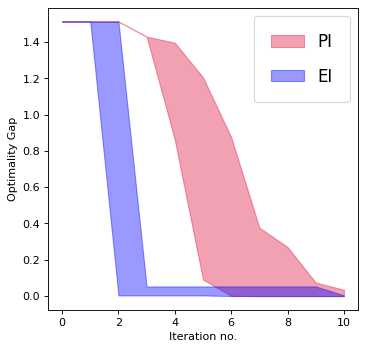

In [68]:
## plot showing optimality gap between max value obtained in each iteration and best value that can be obtained in the bound for two different aquisition functions - PI and EI. 
x = range(11)
y = []
y1 = []
y2 = []
for i in range(11):
  mean = np.mean(dp_PI[:,i])
  dev_up = np.max(dp_PI[:,i])
  dev_down = np.min(dp_PI[:,i])
  y.append(mean)
  y1.append(dev_up)
  y2.append(dev_down)
fig = plt.figure(num=1, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.fill_between(x, y1, y2, color="crimson", alpha=0.4,label='PI')
x = range(11)
y = []
y1 = []
y2 = []
for i in range(11):
  mean = np.mean(dp_EI[:,i])
  dev_up = np.max(dp_EI[:,i])
  dev_down = np.min(dp_EI[:,i])
  y.append(mean)
  y1.append(dev_up)
  y2.append(dev_down)

ax.fill_between(x, y1, y2, color="blue", alpha=0.4,label = 'EI')
ax.legend(loc='upper right', borderpad=1, labelspacing=1,prop={'size':15})
ax.set_ylabel("Optimality Gap")
ax.set_xlabel("Iteration no.")
plt.show(1)